<a href="https://colab.research.google.com/github/francji1/01ZLMA/blob/main/code/01ZLMA_ex10_Poisson_2b_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 10
Exercise 10 of the course 01ZLMA.

## Contents

* Log-linear models with Poisson distributed data
 ---


Dataset and example from Chapter 10

Peter K. Dunn • Gordon K. Smyth, Generalized Linear ModelsWith Examples in R

https://link.springer.com/content/pdf/10.1007%2F978-1-4419-0118-7.pdf

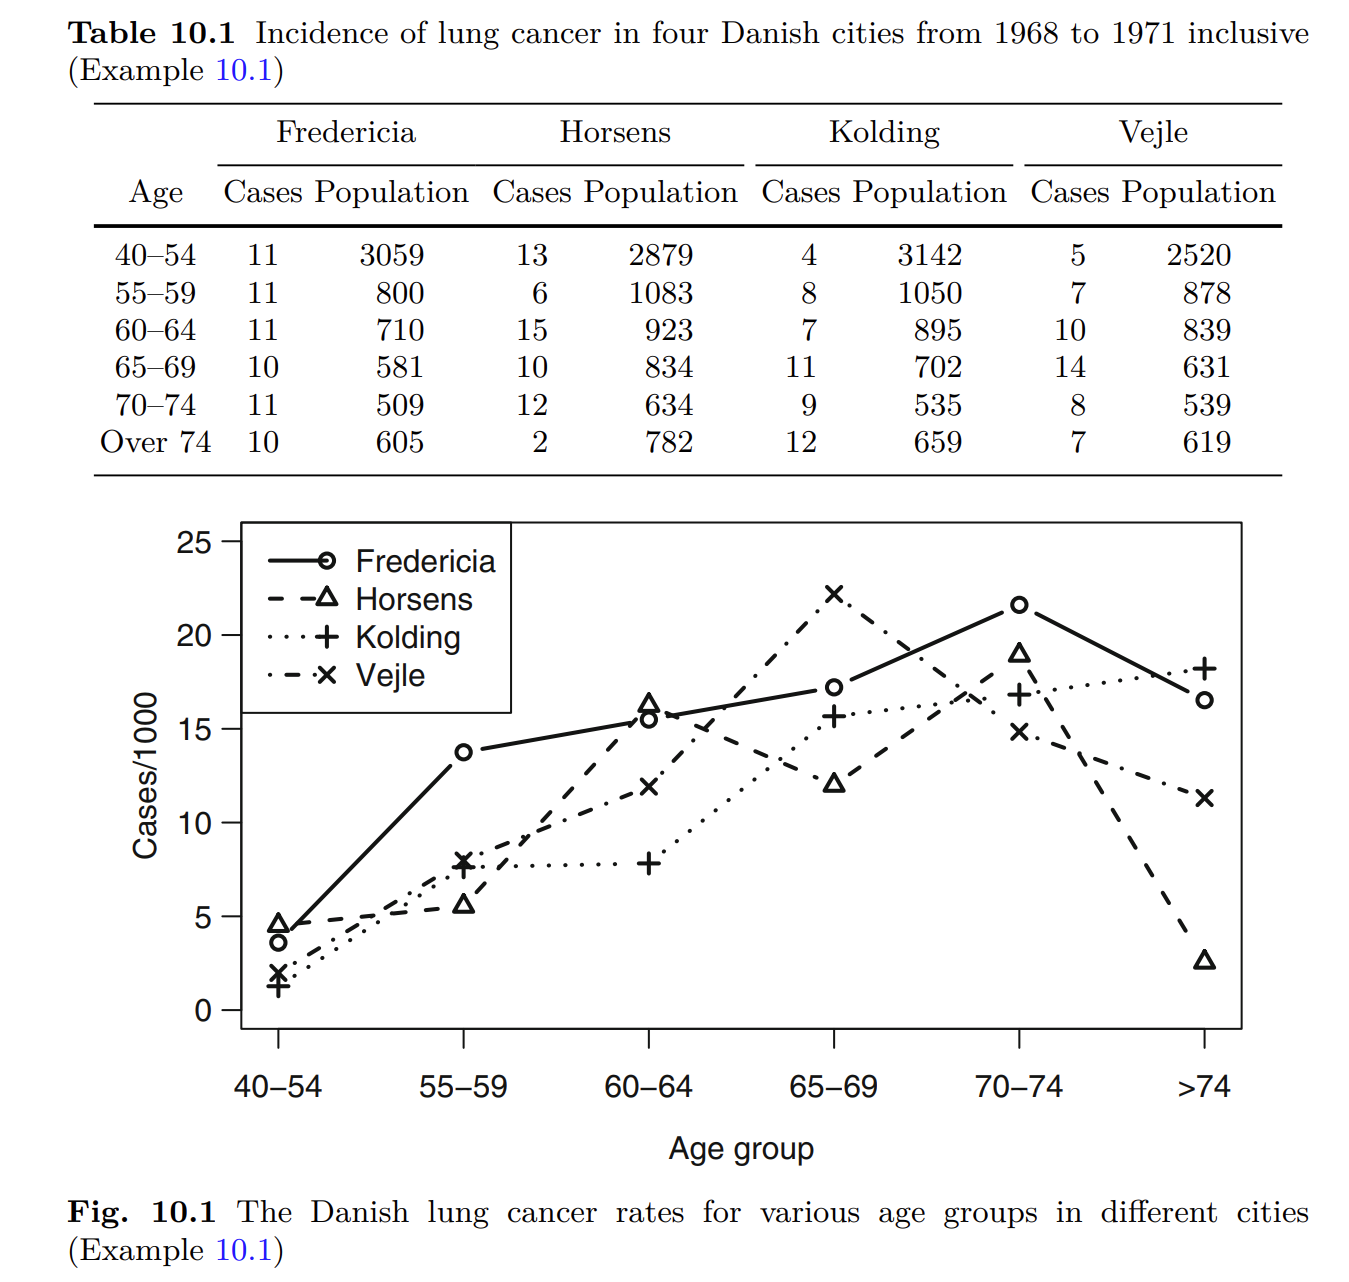

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.genmod.families.links import Logit, Probit, Cauchy, CLogLog, LogLog
import statsmodels.api as sm
import statsmodels.formula.api as smf



In [ ]:
# Set the display width to avoid automatic wrapping of the display
pd.set_option('display.width', 200)

# Increase maximum column width to see more data within each cell
pd.set_option('display.max_colwidth', 50)

In [ ]:

# Please note that this cell works may not work in other env-s that Google Colab
!pip install wget
import wget
url = "https://github.com/francji1/01ZLMA/raw/main/code/helpers.py"
wget.download(url, '../content/helpers.py')  # path where Colab can find libraries
from helpers import Anova
anova = Anova()

In [ ]:
# Load the R magic extension
%load_ext rpy2.ipython

In [ ]:
%%R -o danishlc
library(tidyverse)
install.packages("GLMsData")
library(GLMsData)
data(danishlc)
options(contrasts= c("contr.treatment", "contr.treatment"))

### Poission regression recap:

We assume:

$Y_i \sim Po(\lambda_i s_i)$

$log(\lambda_i) = x_i^T \beta$

$E[Y_i] = \lambda_i s_i = s_i exp(x_i^T \beta) = exp(ln(s_i) + x_i^T \beta)$

$\lambda_i = \frac{E[Y_i]}{s_i}$

We will estimate coefficients $β_j$'s, but we don't have to estimate parameters for an offset term $ln(si)$.



In [ ]:
# Ensure the 'Age' column is treated as an ordered categorical variable
age_categories = pd.CategoricalDtype(categories=["40-54", "55-59", "60-64", "65-69", "70-74", ">74"], ordered=True)
danishlc['Age'] = danishlc['Age'].astype(age_categories)
danishlc['Rate'] = danishlc['Cases'] / danishlc['Pop'] * 1000

data = danishlc.copy()

Example 10.1.: As a numerical example, consider the number of incidents of
lung cancer from 1968 to 1971 in four Danish cities. The number of cases of lung cancer in each age group is remarkably similar for Fredericia. However, using the number of cases does not accurately reflect the information in the data, because five times as many people are in the 40–54 age group than in the
over-75 age group. Understanding the data is enhanced by considering the
rate of lung cancer, such as the number of lung cancer cases per unit of population.

In [ ]:
# Plotting with matplotlib (similar to matplot in R)
fig, ax = plt.subplots()
for key, grp in data.groupby(['City']):
    ax = grp.plot(ax=ax, kind='line', x='Age', y='Rate', label=key, marker='o')

plt.title('Cases per 1000 by Age Group and City')
plt.xlabel('Age Group')
plt.ylabel('Cases per 1000')
plt.grid(True)
plt.legend(title='City')
plt.show()


In [ ]:
# Plotting with seaborn (similar to ggplot in R)
sns.lineplot(data=data, x='Age', y='Rate', hue='City', style='City', markers=True, dashes=False)
plt.xlabel('Age group')
plt.ylabel('Cases/1000')
plt.title('Lung Cancer Rates by City and Age Group')
plt.show()


The plots show no clear pattern by city, but the
lung cancer rate appears to grow steadily for older age groups for each city,
then falls away for the `>74` age group. The lung cancer rate for Horsens in
the `>74` age group seems very low.

In [ ]:
# Prepare the dataset
data = pd.DataFrame({
    'Cases': [11, 11, 11, 10, 11, 10, 13, 6, 15, 10, 12, 2, 4, 8, 7, 11, 9, 12, 5, 7, 10, 14, 8, 7],
    'Pop': [3059, 800, 710, 581, 509, 605, 2879, 1083, 923, 834, 634, 782, 3142, 1050, 895, 702, 535, 659, 2520, 878, 839, 631, 539, 619],
    'Age': ["40-54", "55-59", "60-64", "65-69", "70-74", ">74"] * 4,
    'City': ["Fredericia"]*6 + ["Horsens"]*6 + ["Kolding"]*6 + ["Vejle"]*6  # object
})

data['Rate'] = data['Cases'] / data['Pop'] * 1000
age_order = ["40-54", "55-59", "60-64", "65-69", "70-74", ">74"]
data['Age'] = pd.Categorical(data['Age'], categories=age_order, ordered=True) # category
data['age'] = data['Age'].cat.codes # numeric integer
data

In [ ]:
data.dtypes

In [ ]:
%%R

dlc.m1 <- glm( Cases ~ offset( log(Pop) ) + City * Age, family=poisson, data=danishlc)
anova(dlc.m1, test="Chisq")

In [ ]:
# Model 1 with offset term and factors City, Age and their interaction
formula_m1 = 'Cases ~  City * C(age)'
# formula_m1 = 'Cases ~  City * Age' # same

# Define the offset
offset = np.log(data['Pop'])

model_m1 = smf.glm(formula=formula_m1, data=data, offset=offset, family=sm.families.Poisson()).fit()
print(model_m1.summary())


In [ ]:
# Model 2 with offset term and factors City, Age without interaction
formula_m2 = 'Cases ~  City + Age'

model_m2 = smf.glm(formula=formula_m2, data=data, offset=offset, family=sm.families.Poisson()).fit()
print(model_m2.summary())

In [ ]:
anova(model_m1, model_m2, test="Chisq")


In [ ]:
%%R

danishlc$Rate <- danishlc$Cases / danishlc$Pop * 1000 # Rate per 1000
danishlc$Age <- ordered(danishlc$Age, # Ensure age-order is preserved
   levels=c("40-54", "55-59", "60-64", "65-69", "70-74", ">74") )
danishlc$age = as.factor(as.numeric(danishlc$Age))

dlc_m1 <- glm( Cases ~ offset( log(Pop) ) + City * age, family=poisson, data=danishlc)
dlc_m2 <- glm( Cases ~ offset( log(Pop) ) + City + age, family=poisson, data=danishlc)
summary(dlc_m1)

In [ ]:
%%R

# Test predictors significance:
print(anova(dlc_m1, test="Chisq"))
# Model without interaction
print(anova(dlc_m2, test="Chisq"))


In [ ]:
%%R
# More tests:
print(anova(dlc_m1, dlc_m2, test = "LRT"))
print(anova(dlc_m1, dlc_m2, test = "Rao"))


Keep only `Age`

In [ ]:
# Model 3 with offset term and only one factor Age
formula_m3 = 'Cases ~  Age'

model_m3 = smf.glm(formula=formula_m3, data=data, offset=offset, family=sm.families.Poisson()).fit()
print(model_m3.summary())

Mutate dataset to have Age as quantitative. Using the lower class boundary of each class, since all classes have a lower
boundary.

In [ ]:
%%R
# Add numerical variable: AgeNum.
danishlc <- danishlc %>%
 add_column(AgeNum = rep( c(40, 55, 60, 65, 70, 75), 4))


Question: Discuss the application of different boundaries: lower, midpoint, upper.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

data['AgeNum'] = np.tile([40, 55, 60, 65, 70, 75], 4)
data


In [ ]:
model_m4 = smf.glm('Cases ~ AgeNum', data=data, family=sm.families.Poisson(), offset=np.log(data['Pop'])).fit()
print(model_m4.summary())


In [ ]:
# Generating polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
age_poly = poly.fit_transform(data[['AgeNum']])
data['AgeNum_lin'] = age_poly[:, 0]  # Linear term
data['AgeNum_quad'] = age_poly[:, 1]  # Quadratic term
print(data)
# Fitting the model with linear and quadratic terms
model_m5 = smf.glm('Cases ~ AgeNum_lin + AgeNum_quad', data=data, family=sm.families.Poisson(), offset=np.log(data['Pop'])).fit()
print(model_m5.summary())


In [ ]:
y = data['Cases']
mu_hat4 = model_m4.fittedvalues
dev_stat_m4 = 2 * np.sum(y * np.log(y / mu_hat4) - (y - mu_hat4))
deviance_comparison = pd.DataFrame({
    'computed_by': ['hand', 'glm in R'],
    'deviance': [dev_stat_m4, model_m4.deviance]
})
print(deviance_comparison)


In [ ]:
# Compare linear and quadratic models.
anova(model_m4,model_m5, test="Chisq")

In [ ]:
%%R
# Add numerical variable: AgeNum.
danishlc <- danishlc %>%
 add_column(AgeNum = rep( c(40, 55, 60, 65, 70, 75), 4))

# Build model 4 with Age as numerical variable.
dlc_m4 <- update(dlc_m1, . ~ offset( log(Pop) ) + AgeNum)
print(summary(dlc_m4))
anova(dlc_m4, test="Chisq")

In [ ]:
%%R
# With numerical varaible, we can apply quadratic relationship
dlc_m5 <- glm( Cases ~ offset( log(Pop) ) + AgeNum + I(AgeNum^2), family=poisson, data=danishlc)
print(summary(dlc_m5))
anova(dlc_m5, test="Chisq")

In [ ]:
%%R
# Compare linear and quadratic models.
anova(dlc_m4,dlc_m5, test="Chisq")

The quadratic model is significant improvement compare to linear one.

Just for academic purpose: Check the deviance by hand computation

In [ ]:
%%R
y <- danishlc$Cases
mu_hat4 <- fitted(dlc_m4)               # predicted values by model 1
dev_stat_m4 <- 2*sum(y*log(y/mu_hat4) - (y - mu_hat4))
data.frame(computed_by = c("hand","glm in R"), deviance = c(dev_stat_m4,deviance(dlc_m4)))


### *Results*

Compare models with numerical `AgeNum` and with categorical `Age` variable by AIC and create summary table of outputs from all models

In [ ]:
from scipy.stats import chi2

models = {'m1': model_m1, 'm2': model_m2, 'm3': model_m3, 'm4': model_m4, 'm5': model_m5}
results = pd.DataFrame({
    'model_name': ['model_m1', 'model_m2', 'model_m3', 'model_m4', 'model_m5'],
    'age_type': ['categorical', 'categorical', 'categorical', 'numerical', 'numerical'],
    'model_type': ['with interaction', 'without interaction','Age only',  'AgeNum Linear', 'AgeNum Quadratic']
})

results['AIC'] = [model.aic for model in models.values()]
results['deviance'] = [round(model.deviance, 2) for model in models.values()]
results['df'] = [model.df_resid for model in models.values()]
results['c_val'] = results['df'].apply(lambda x: chi2.isf(0.05, x) if x > 0 else np.nan)
results['P_val'] = results.apply(lambda row: chi2.sf(row['deviance'], row['df']), axis=1)

print(results)


In [ ]:
%%R
print(AIC(dlc_m1))
print(AIC(dlc_m2))
#print(AIC(dlc_m3))
print(AIC(dlc_m4))
print(AIC(dlc_m5))

In [ ]:
# Plotting deviance residuals against fitted values
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted for a single row of two plots

# For model_m3
predicted_m3 = model_m3.predict()
resid_standard_m3 = model_m3.resid_deviance
axs[0].scatter(predicted_m3, resid_standard_m3, color='gray')  # Corrected indexing
axs[0].set_title('model_m3 Response vs. Deviance Residuals')

# For model_m5
predicted_m5 = model_m5.predict()
resid_standard_m5 = model_m5.resid_deviance
axs[1].scatter(predicted_m5, resid_standard_m5, color='gray')  # Corrected indexing
axs[1].set_title('model_m5 Response vs. Deviance Residuals')

plt.tight_layout()
plt.show()


In [ ]:
# Plot residuals against predictors
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
age_numeric = data['AgeNum'].astype(float)
age_factor = data['Age'].cat.codes

# For model_m3
axs[0, 0].scatter(data['Age'], resid_standard_m3, color='gray')
axs[0, 1].scatter(age_numeric, resid_standard_m3, color='gray')
axs[0, 2].scatter(age_numeric, resid_standard_m3, color='gray')

# For model_m4
axs[1, 0].scatter(data['Age'], resid_standard_m5, color='gray')
axs[1, 1].scatter(age_numeric, resid_standard_m5, color='gray')
axs[1, 2].scatter(age_numeric ** 2, resid_standard_m5, color='gray')

plt.tight_layout()
plt.show()

# Checking the link function
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(predicted_m3, model_m3.resid_response, color='gray')
axs[0].set_title('Response vs. Working Residuals for model_m2')
axs[1].scatter(predicted_m5, model_m5.resid_response, color='gray')
axs[1].set_title('Response vs. Working Residuals for model_m4')

plt.tight_layout()
plt.show()


In [ ]:
%%R
x       <- list(m1=dlc_m1,m2=dlc_m2,m3=dlc_m4,m4=dlc_m5)
results <- data.frame(model_name = c("dlc_m1","dlc_m2","dlc_m4","dlc_m5"),
       age_type = c("categorical","categorical","numerical","numerical"),
       model_type = c("without interaction","with interaction","AgeNum Linear", "AgeNum quadratic"))

results <- tibble::rownames_to_column(results, var = "model_number") %>%
 add_column(AIC = as.numeric(lapply(x,AIC)),
            deviance = lapply(x,deviance) %>% as.numeric() %>% round(2),
            df = lapply(x,df.residual) %>% as.numeric()) %>%
  mutate(c_val = ifelse(df>0,qchisq(0.05, df, ncp=0, lower.tail = FALSE),NA),
         P_val = ifelse(df>0,pchisq(deviance, df, lower = FALSE),NA)  )
results


Both models, with factor varialbe `Age` and with quadratic `AgeNum` are reasonably adequate.

Plot deviance residuals against fitted values

In [ ]:
%%R
par(mfrow=c(2,2))
scatter.smooth(predict(dlc_m2, type='response'), rstandard(dlc_m2, type='deviance'))
scatter.smooth(sqrt(fitted(dlc_m2)), rstandard(dlc_m2, type='deviance'))

scatter.smooth(predict(dlc_m4, type='response'), rstandard(dlc_m4, type='deviance'))
scatter.smooth(sqrt(fitted(dlc_m4)), rstandard(dlc_m4, type='deviance'))

Question: why to plot sqrt of fitted values istead of fitted values only?

Plot residuals against predictors



In [ ]:
%%R
par(mfrow=c(2,3))
plot(danishlc$Age,  rstandard(dlc_m2, type='deviance'), col='gray')
plot(as.numeric(danishlc$Age),  rstandard(dlc_m2, type='deviance'), col='gray')
scatter.smooth(danishlc$AgeNum,  rstandard(dlc_m2, type='deviance'), col='gray')

scatter.smooth(danishlc$Age, rstandard(dlc_m4, type='deviance'), col='gray')
scatter.smooth(danishlc$AgeNum, rstandard(dlc_m4, type='deviance'), col='gray')
scatter.smooth(danishlc$AgeNum^2, rstandard(dlc_m4, type='deviance'), col='gray')


Checking the link function

In [ ]:
%%R
par(mfrow=c(1,2))
scatter.smooth(predict(dlc_m2, type='response'), resid(dlc_m2, type='working'), col='gray')
scatter.smooth(predict(dlc_m4, type='response'), resid(dlc_m4, type='working'), col='gray')

Checking if Poisson regression is appropriate

Quantile residuals:

Dunn and Gordon (2018) introduce quantile residuals for discrete response variables. Their primary benefits are they do not show weird patterns (due to variable’s discreteness).

In [ ]:
%%R
install.packages("statmod")
library(statmod) # For quantile residuals
install.packages("surveillance")
library(surveillance) # For anscombe residuals


In [ ]:
%%R
selected_model = dlc_m2
par(mfrow=c(2,4))
qqnorm(qresid(selected_model))
qqline(qresid(selected_model))
qqnorm(rstandard(selected_model, type="pearson")); qqline(qresid(selected_model))
qqnorm(rstandard(selected_model, type="deviance")); qqline(qresid(selected_model))
qqnorm(anscombe.residuals(selected_model, 1)); qqline(qresid(selected_model))


qqnorm(qresid(dlc_m5))
qqline(qresid(dlc_m5))
qqnorm(rstandard(dlc_m5, type="pearson")); qqline(qresid(dlc_m5))
qqnorm(rstandard(dlc_m5, type="deviance")); qqline(qresid(dlc_m5))
qqnorm(anscombe.residuals(dlc_m5, 1)); qqline(qresid(dlc_m5))



Outliers and influential observations



In [ ]:
%%R
n = 24
# Critical value for cook distance: 8/(n-2*p)
# Critical value for hat values: 2*p/n
selected_model = dlc_m4
par(mfrow=c(1,2))
plot(cooks.distance(selected_model), type='h',las=1, main="Cook's D",ylab="Cook's distance, D")
plot(hatvalues(selected_model),ylim=c(0,1))
abline(2*(n-df.residual(selected_model))/n,0)

plot(cooks.distance(dlc_m5), type='h',las=1, main="Cook's D",ylab="Cook's distance, D")
plot(hatvalues(dlc_m5),ylim=c(0,1))
abline(2*(n-df.residual(dlc_m5))/n,0)


In [ ]:
%%R
influence.measures(dlc_m2)
influence.measures(dlc_m4)


In [ ]:
 %%R
 which(influence.measures(dlc_m4)$is.inf[,'cook.d'] )
 which(influence.measures(dlc_m4)$is.inf[,'hat'] )

Task:


HW:
* Plot predictions and realization of cases from previous model.
* Do we have enough realizaions in each group? If is the minimum number of realizations violated, select similar groups and merge them.
* Re-run the analysis again with such a newly grouped dataset.
* Transform data frame into the long format with new variable `cancer` with levels `yes` and `no`.
* Can you model the previous problem with binomial distribution?
* If so, do you do it. Run the experiment and model the probability of lung cancer. What is the odds ratio between people living in different locations? What is the odds ratio between people ten years older?
* Run the analysis with new contingency table, where columns are `cancer`, `age`, `city`, `number` (number of population in the group).
* Compare the relative risk with odds ratios for given City and between people ten years older.

In [ ]:
data